<a href="https://colab.research.google.com/github/f-ssemwanga/object-detection-cnn/blob/main/catClassification_colabVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Deep Learning in practice

#### In this activity I will build a simple cat neural network classifier with TensorFlow 2.0

* Build a neural network that classifies cat images
* Train the neural network
* and finally, evaluate the accuracy of the model

* **PIL** (Python Imaging Library) is the python Imaging library that adds support for opening, manipulating, and saving many different image file formats.
* **random** implements pseudo random number generators for various distributions
* **numpy**  for numpy array manipulation - every image must be embedded into a numpy before it can be used as input for a neural network
* **os** operating system module and allows access to folders and files stored in the hard drive - useful for navigating the file system
* **tensorflow.keras** tensorflow module that will be used to build our neural network model

In [2]:
#mount the drive file system
from google.colab import drive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
#importing the required libraries
import tensorflow  as tf
print(tf.__version__)

#import pillow
from PIL import Image
from random import shuffle, choice

#import numpy arrays library
import numpy as np

#import os module
import os
#import keras and its libs
from tensorflow.keras import datasets, layers, models

#stop the execution from hanging, add this line to run training without interruption
os.environ ['KMP_DUPLICATE_LIB_OK'] = 'True'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime

2.15.0


### One-Hot Encoding

One-hot encoding takes a string as a parameter, and creates a label to the image.  Note that the label for a cat is  the numpy array [1,0] and the label for no cat is [0,1].  This technique is very common in machine learning.  **One-hot encoding** is a process by which categorical variables from string format to numerical format i.e. are converted into a format that could be provided to an ML algorithm to do a better prediction job.

*In one-hot encoding you create a vector containing all zeros except in one location*

The labels in the training data need to be one-hot encoded!

Think of a one-hot coded array [1,0] being the probability in this example of being or not being a cat

In [5]:
IMAGE_SIZE = 256 # we will be resizing the images to 256x256 pixels, this is a changeable hyperparameter
#increasing image size = longer training time but better accuracy
def one_hot_encode(className):
  '''One-hot encodes a given class'''
  if className == 'cats':return np.array([1,0])
  elif className =='nocats': return np.array([0,1])
  else: raise ValueError(f'Unknown class name: {className}')

In [6]:
print(f"cats: {one_hot_encode('cats')}")
print(f"cats: {one_hot_encode('nocats')}")

cats: [1 0]
cats: [0 1]


#### Loading the training data
The function **load_data** is responsible for loading the dataset.  First we set the IMAGE_DIRECTORY variable to point at the training dataset 'datasets/training_set'

The training data will be loaded into the list **train_data**.  Initially the list is empty.  Then the variable directories will get the tree structure of all directories in the specified path.

**os.walk()** generates the filenames in the directory tree by walking the tree either top-down or bottom-up.  For each directory in the tree rooted at directory top (including itself), it yields a 3-tuple (dirpath, dirnames, filenames)
* root: Prints out directories only from what we have specified
* dirs: Prints out sub-directories from the root
* files: Prints out all files from root and directories.

**os.path.join()** this python method joins one or more components intelligently.  This method concatenates various path components with exactly  one directory separator ('/') following each non-empty part except  the last path component.  If the last path component to be joined is empty then a directory separator('/' is put at the end.  If a path component represents an  absolute path, then all previous components joined are discarded and joining continues from the absolute path component)

In [8]:
#if running in colab amend the path as follows:
PROJECT_PATH = '/content/drive/My Drive/Colab Notebooks/'

# demo for generation of the os.walk(IMAGE_DIRECTORY) generator object and iteration on it
IMAGE_DIRECTORY = PROJECT_PATH+'datasets/training_set'
print(f"os.walk(IMAGE_DIRECTORY: {os.walk(IMAGE_DIRECTORY)}")

#iterate over the generator object
i=0
for root, sub_directories, files in (os.walk(IMAGE_DIRECTORY)):
  print(f'Level {i}')
  print(f'root folder: {root}')
  print(f'sub folders: {sub_directories}')
  print(f'number of files in the root folder: {len(files)}')
  i +=1
  print("-"*35)

#returning folders we use the next method
folders = next(os.walk(IMAGE_DIRECTORY))
print(f'paths_tuple in the current directory: \n{folders}')
#returning the root folder
print(f'ROOT FOLDER:{folders[0]}')
#Sub directories in root
print(f'Subdirectories from the root: {folders[1]}')

#access the files
#print(f'Files at the root directory: {folders[2]}')

#directories
training_data_directory = folders[1]
print(f'Training Data Directory: {training_data_directory}')
cats_directory = training_data_directory[0]
nocats_directory = training_data_directory[1]

#reading the images with os.path.join()
joint_path = os.path.join(IMAGE_DIRECTORY,cats_directory)
print(f'Joint Path: {joint_path}')
images_list = next(os.walk(joint_path))[2] # file names are at index 2
print(f'number of images: {len(images_list)}') #prints images
#print(f'Image List: {images_list}')

os.walk(IMAGE_DIRECTORY: <generator object _walk at 0x7bb17c86eb90>
Level 0
root folder: /content/drive/My Drive/Colab Notebooks/datasets/training_set
sub folders: ['cats', 'nocats', '.ipynb_checkpoints']
number of files in the root folder: 0
-----------------------------------
Level 1
root folder: /content/drive/My Drive/Colab Notebooks/datasets/training_set/cats
sub folders: []
number of files in the root folder: 548
-----------------------------------
Level 2
root folder: /content/drive/My Drive/Colab Notebooks/datasets/training_set/nocats
sub folders: []
number of files in the root folder: 1669
-----------------------------------
Level 3
root folder: /content/drive/My Drive/Colab Notebooks/datasets/training_set/.ipynb_checkpoints
sub folders: []
number of files in the root folder: 0
-----------------------------------
paths_tuple in the current directory: 
('/content/drive/My Drive/Colab Notebooks/datasets/training_set', ['cats', 'nocats', '.ipynb_checkpoints'], [])
ROOT FOLDER:/co

Observe that the tree contains three main levels.  the root level (level 0) contains the root directory which is "./data/training_set".  The second level (index=1) corresponds to the two folders inside the root folder, namely the 'cats' and 'nocats' folder.  The third level(index=2) corresponds to the hidden folder '.DS_Store'

In [39]:

def load_data (IMAGE_DIRECTORY, number_of_images = 100, shuffle_data = True,dataSetType=None, tType="training" ):
  '''Loads the required image data'''

  if dataSetType is None:
    dataSetType =[]

  print('loading images...')
  folders = next(os.walk(IMAGE_DIRECTORY))[1] # getting the sub directories

  for folder_name in folders:
    if folder_name: # ensure folder_name is not empty
      print(f'loading {folder_name}')
      file_names = next(os.walk(os.path.join(IMAGE_DIRECTORY, folder_name)))[2]
      for i in range(min(number_of_images, len(file_names))):
        image_name = choice(file_names)
        image_path=os.path.join(IMAGE_DIRECTORY, folder_name, image_name)

        if "DS_Store" not in  image_path:
          try:
              label = one_hot_encode(folder_name)
              class_name = folder_name
              img = Image.open(image_path) #Image.open() is part of the PILLOW library
              img = img.convert('L') #converts the image to grayscale
              img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.LANCZOS) # resize and improve quality
              dataSetType.append([np.array(img), label, class_name]) # class name is only needed for visualisation
          except ValueError as e:
            print(e)
          except Exception as e:
            print(f'Error loading image {image_path}: {e}')
  if(shuffle_data == True):
    shuffle(dataSetType)
  print(f'we loaded, {len(dataSetType)}, images in the {tType} dataset')
  return dataSetType

#### Using the PILOW library to read image data from the file names

for i in range(number of images):
  image_path = choice(file_names)
  image_path = os.path.join(IMAGE_DIRECTORY, folder_name, image_name)
  label = one_hot_encode(folder_name)
  if "DS_Store" not in image_path:
    img = Image.open(image_path)
    img = img.convert('L')
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.ANTIALIAS)
    train_data.append([np.array(img), label])

* **choice(file_names):** returns a random item from a list, tuple, or string - file_names is the image list in this case
* **Image.open(image_path):** open an image fro the path specified
* **img.resize:** resizes the image to the specified size
* **ANTIALIAS:** It is a filter that ensures the best quality
* **train_data.append([np.array(img), label]):** add the training images and their labels into the list
* **np.array(img):** cast the image into a numpy array

#### Load and VISUALISE Some Images

In [40]:
#check duration of loading the data
t0 = datetime.datetime.now()
IMAGE_DIRECTORY = PROJECT_PATH +'datasets/training_set'
train_data = load_data(IMAGE_DIRECTORY, number_of_images=200, dataSetType=[], tType="training")
t1 = datetime.datetime.now()
print(f'time duration to load data: {t1-t0}')
#print(train_data)


loading images...
loading cats
loading nocats
loading .ipynb_checkpoints
we loaded, 400, images in the training dataset
time duration to load data: 0:00:17.226295


label [1 0]
class name: cats


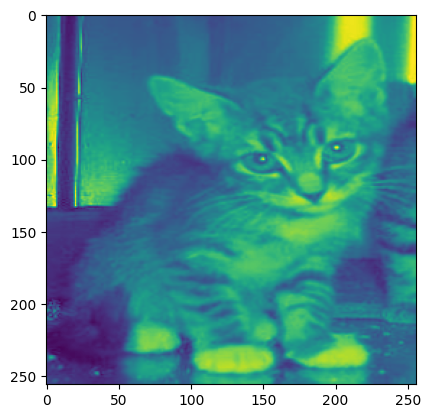

In [20]:
image_index =1
label = train_data[image_index][1]
class_name = train_data[image_index][2]
np_image =train_data[image_index][0]
print(f'label {label}')
print(f'class name: {class_name}')
image = plt.imshow(np_image) #display the image itself

label [1 0]
class name: cats


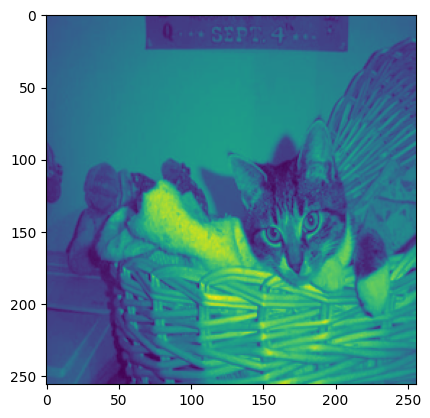

In [21]:
image_index =100
label = train_data[image_index][1]
class_name = train_data[image_index][2]
np_image =train_data[image_index][0]
print(f'label {label}')
print(f'class name: {class_name}')
image = plt.imshow(np_image) #display the image itself

#### Building the Neural Network Model

Now that we have the dataset, we will prepare to create neural networks.

We will create two types of networks.  One fully connected neural network and one convolutional neural network.


#### Re-shape input array

In [22]:
# Convert the first element of each item in train_data (which are the images) into a NumPy array,
# and reshape it to have the shape (-1, IMAGE_SIZE, IMAGE_SIZE, 1). The -1 means that the size
# of this dimension is inferred from the length of the array and the remaining dimensions.
# This reshaping step ensures that the images have the correct format expected by the model,
# with the last dimension being 1 to represent the grayscale channel.
trainX = np.array([i[0] for i in train_data]).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)

# Convert the second element of each item in train_data (which are the one-hot encoded labels)
# into a NumPy array. This will create an array where each element is a one-hot encoded vector
# representing the class label of the corresponding image.
trainY = np.array([i[1] for i in train_data])

print(trainX.shape)
print(trainY.shape)

(400, 256, 256, 1)
(400, 2)


In [42]:
#load test data
t0 - datetime.datetime.now()
IMAGE_DIRECTORY = PROJECT_PATH +'datasets/test_set'
test_data = load_data(IMAGE_DIRECTORY, number_of_images=100, shuffle_data=True, dataSetType=[], tType="testing")
t1 = datetime.datetime.now()
print(f'Time taken to load data: {t1-t0}')

#reshape input arrays for the model
testX = np.array([i[0] for i in train_data]).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
testY = np.array([i[1] for i in train_data])
print(testX.shape)
print(testY.shape)



loading images...
loading nocats
loading cats
we loaded, 199, images in the testing dataset
Time taken to load data: 0:04:44.796413
(400, 256, 256, 1)
(400, 2)


#### Model Creation

In [43]:
def create_cnn_model():
  '''Creates a CNN'''
  model = tf.keras.models.Sequential()
  #----------- start of feature extraction layers -----------------------------------

  model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu',
                          input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))

  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, kernel_size=(3,3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(256, kernel_size=(3,3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5)) # reduce overfitting recommended value is 0.5
  #Output from the convolutional layers is a summary of the most important features
  #------------------------------- end of feature extraction layers--------------------
  model.add(layers.Flatten()) # all features become one row i.e. flatten into 1D vector
  #-------------- Start of the classification layers  / head of the model--------------
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(2, activation ='softmax'))
  #softmax function returns a vector that contains two probabilities.  e.g. [0.7, 0.3]
  #----------------------- End of the classification layers -----------------------------
  return model

#### Compile the model

In [44]:
print('creating model')
model = create_cnn_model()
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

creating model


#### Train the Model

In [47]:
print('Training model')
BATCH_SIZE = 64
EPOCHS = 100
history = model.fit(trainX, trainY,
                    batch_size = BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose =1,
                    validation_data =(testX, testY)
                    )

Training model
Epoch 1/100
7/7 [==============================] - 2s 252ms/step - loss: 0.0455 - accuracy: 0.9900 - val_loss: 0.5640 - val_accuracy: 0.6900
Epoch 2/100
7/7 [==============================] - 2s 238ms/step - loss: 0.0415 - accuracy: 0.9900 - val_loss: 0.5543 - val_accuracy: 0.6800
Epoch 3/100
7/7 [==============================] - 2s 259ms/step - loss: 0.0412 - accuracy: 0.9875 - val_loss: 0.5676 - val_accuracy: 0.6925
Epoch 4/100
7/7 [==============================] - 2s 260ms/step - loss: 0.0232 - accuracy: 0.9975 - val_loss: 0.5529 - val_accuracy: 0.6900
Epoch 5/100
7/7 [==============================] - 2s 244ms/step - loss: 0.0218 - accuracy: 1.0000 - val_loss: 0.5445 - val_accuracy: 0.7025
Epoch 6/100
7/7 [==============================] - 2s 240ms/step - loss: 0.0303 - accuracy: 0.9950 - val_loss: 0.5361 - val_accuracy: 0.7225
Epoch 7/100
7/7 [==============================] - 2s 240ms/step - loss: 0.0169 - accuracy: 0.9975 - val_loss: 0.5772 - val_accuracy: 0.700

* if the training accuracy is excellent e.g. 100% but the validation accuracy is low then we would say we have **overfitting** i.e. the model is doing too well on what it has seen but poor at at generalising on the unseen data.

* These results indicate that the model has achieved perfect accuracy on the training data (100%) but has a significantly lower accuracy on the validation data (73.25%). This discrepancy is a clear sign of overfitting

**Possible Solution**
* Increase the size of the training dataset i.e. add more images in the dataset
* Introduce Data augmentation
* Reduce the size of the neural network model i.e. have less learnable parameters

In [48]:
#Check model's summary for trainable parameters
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 127, 127, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                      